# PINN-MPC: Physics-Informed Neural Network for Nonlinear MPC

This notebook implements a **Physics-Informed Neural Network (PINN)** as an explicit **Model Predictive Controller (MPC)** for a nonlinear water tank system. The controller, trained entirely offline, learns to generate optimal control trajectories that satisfy the system dynamics, track a reference set-point, and respect input/state constraints.

The notebook is organized into sections for:
- Training the PINN-MPC using a custom composite loss,
- Validating its performance on set-point and disturbance scenarios and   inspecting plot results for closed-loop performance


The training settings, loss weights, and simulation parameters can be customized to explore different control configurations.


**Import Libraries**

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

from __future__ import annotations
import argparse
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
from itertools import product
import itertools
import matplotlib.cm as cm
from typing import Sequence, Union
from matplotlib.ticker import MultipleLocator

**Select Device**

In [ ]:
## ---------------------------- SELECT DEVICE ------------------------------- ##

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA GPU found")

CUDA available: True
CUDA device count: 1
Device name: NVIDIA GeForce RTX 3060 Ti


### Open-Loop

Theoretical steady-state: 2.041
Settling time: 17.53 seconds


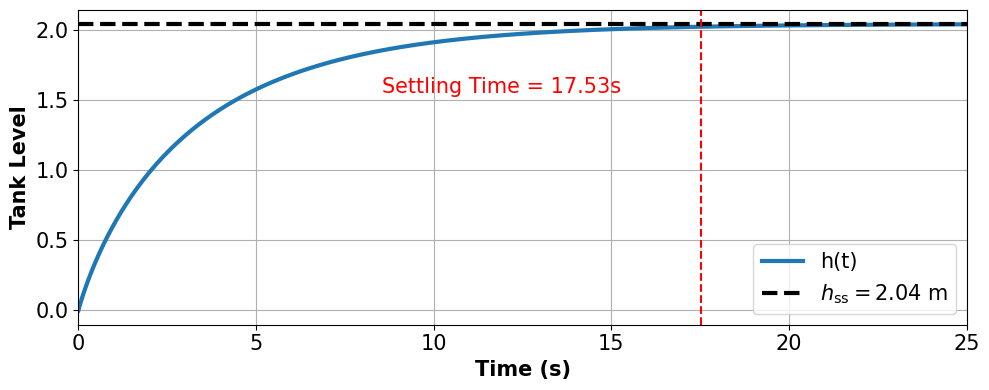

In [ ]:
def simulate_tank_step_response(h_init=0.0, u=1.0, K_VALVE=0.7, A=1.0,
                                dt=0.01, simulation_time=25.0, d=0.0, tol=0.01):
    """
    Simulates the open-loop step response of a nonlinear water tank system.

    Args:
        h_init (float): Initial tank level (m).
        u (float): Step inflow rate (m³/s).
        K_VALVE (float): Outflow coefficient (m².⁵/s).
        A (float): Tank cross-sectional area (m²).
        dt (float): Time step for numerical integration (s).
        simulation_time (float): Total simulation duration (s).
        d (float): Constant disturbance flow (m³/s).
        tol (float): Relative tolerance for settling band (as fraction of h_ss).

    Returns:
        t_hist (list): Time history (s).
        h_hist (list): Tank level history (m).
        u_hist (list): Inflow history (m³/s).
        settled_time (float or None): Time when steady-state is reached (s), or None if not settled.
        h_ss (float): Theoretical steady-state level (m).
    """
    steps = int(simulation_time / dt)
    h = h_init

    t_hist = [0.0]
    h_hist = [h_init]
    u_hist = [u]

    t_curr = 0.0
    settled_time = None
    settle_buffer = []

    for _ in range(steps):
        # Compute tank level dynamics
        dh = (u + d - K_VALVE * math.sqrt(max(h, 0.0))) / A
        h = max(h + dh * dt, 0.0)
        t_curr += dt

        # Store simulation data
        t_hist.append(t_curr)
        h_hist.append(h)
        u_hist.append(u)

        # Check for settling within tolerance band
        h_ss = (u + d)**2 / (K_VALVE**2)  # Theoretical steady-state
        if abs(h - h_ss) <= tol * h_ss:
            settle_buffer.append(t_curr)
            if len(settle_buffer) >= int(1.0 / dt):  # 1 second in-band
                if settled_time is None:
                    settled_time = settle_buffer[0]
        else:
            settle_buffer.clear()

    return t_hist, h_hist, u_hist, settled_time, h_ss

# --- Run Simulation ---
t, h, u, settle_time, h_ss = simulate_tank_step_response(dt=0.01, d=0.0, simulation_time=25.0)

print(f"Theoretical steady-state: {h_ss:.3f}")
print(f"Settling time: {settle_time:.2f} seconds" if settle_time else "Did not settle.")

# --- Plot Results ---
plt.figure(figsize=(10, 4))
plt.plot(t, h, label='h(t)', linewidth=3)
plt.axhline(h_ss, color='k', linestyle='--', linewidth=3, label=fr'$h_{{\mathrm{{ss}}}} = {h_ss:.2f}$ m')

if settle_time:
    plt.axvline(settle_time, color='red', linestyle='--')
    plt.text(settle_time - 9.0, h_ss - 0.45, f"Settling Time = {settle_time:.2f}s",
             color='red', fontsize=15, ha='left', va='center')

plt.xlabel("Time (s)", fontweight='bold', fontsize=15)
plt.ylabel("Tank Level", fontweight='bold', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.xlim(0, 25); plt.legend(fontsize=15)
plt.grid(True); plt.tight_layout(); plt.show()


## PINN-MPC Training

### Auxiliary Functions

Number of collocation points: 928


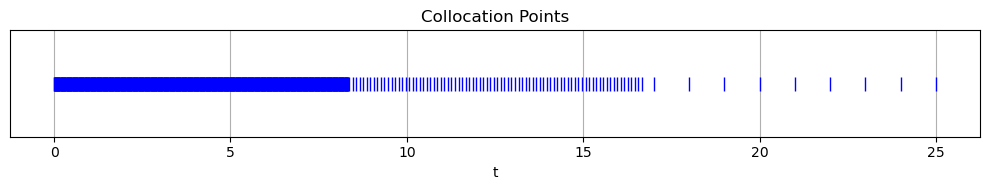

In [ ]:
## ------- GENERATE NON-UNIFORM COLLOCATION POINTS OVER TIME HORIZON -------- ##

def generate_collocation_points(horizon: float,
                                 dt_dense: float = 0.01,
                                 dt_medium: float = 0.05,
                                 dt_sparse: float = 0.1):
    """
    Generates collocation points over a time horizon with non-uniform density.

    The timeline is divided into three backward-stepped regions:
      - Sparse sampling near t = horizon
      - Medium sampling in the middle
      - Dense sampling near t = 0

    The resulting time points are sorted in ascending order and ensure
    inclusion of both t = 0 and t = horizon.

    Args:
        horizon (float): Total time horizon (s).
        dt_dense (float): Time step for dense region near t = 0.
        dt_medium (float): Time step for medium region.
        dt_sparse (float): Time step for sparse region near t = horizon.

    Returns:
        t_col (Tensor): 1D tensor of sorted collocation points on [0, horizon].
    """
    # Define region boundaries (breakpoints)
    t_break1 = 2 * horizon / 3  # sparse > t_break1
    t_break2 = 1 * horizon / 3  # medium > t_break2

    # Sparse region: [horizon → t_break1]
    t_back_sparse = torch.arange(horizon, t_break1, -dt_sparse, device=DEVICE)

    # Medium region: [t_break1 → t_break2]
    t_back_medium = torch.arange(t_break1, t_break2, -dt_medium, device=DEVICE)

    # Dense region: [t_break2 → 0]
    t_back_dense = torch.arange(t_break2, 0.0, -dt_dense, device=DEVICE)

    # Concatenate and ensure both endpoints
    t_col = torch.cat([
        t_back_sparse,
        t_back_medium,
        t_back_dense,
        torch.tensor([0.0, horizon], device=DEVICE)])
    t_col = torch.unique(t_col)        # Remove duplicates
    t_col = torch.sort(t_col).values   # Sort ascending

    # Explicitly ensure 0 and horizon are included
    if t_col[0] > 0:
        t_col = torch.cat([torch.tensor([0.0], device=DEVICE), t_col])
    if t_col[-1] < horizon:
        t_col = torch.cat([t_col, torch.tensor([horizon], device=DEVICE)])

    return t_col

# -------------------------------- Demo ---------------------------------------#
t_col = generate_collocation_points(horizon=25.0, dt_dense=0.01, dt_medium=0.1, dt_sparse=1.0)
print("Number of collocation points:", t_col.shape[0])
# Plot collocation points as vertical tick marks
plt.figure(figsize=(10, 2))
plt.plot(t_col.cpu().numpy(),torch.zeros_like(t_col).cpu().numpy(),'|b', markersize=10)
plt.title("Collocation Points")
plt.xlabel("t"); plt.yticks([])
plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
## ------ SAMPLE TRAINING BATCH OF INITIAL CONDITIONS AND DISTURBANCES ------ ##

def sample_batch(bs, K_VALVE = 0.7, zero_ratio=0.5):
    """
    Samples a batch of initial conditions and setpoints for training/testing.

    Args:
        bs (int): Batch size.
        K_VALVE (float): Outflow coefficient (m².⁵/s).
        zero_ratio (float): Fraction of the batch with zero disturbance (d0 = 0).

    Returns:
        h0 (Tensor): Initial tank levels, shape (bs,)
        u0 (Tensor): Initial control inputs, shape (bs,)
        h_set (Tensor): Desired tank levels (setpoints), shape (bs,)
        d0 (Tensor): Disturbance values, shape (bs,)
    """
    h_max = (1.0 / K_VALVE)**2  # Max achievable h when u=1 and d=0
    h_min = 0.0
    d_max = 0.4

    # Random initial level and control
    h0 = torch.rand(bs, device=DEVICE) * (h_max - h_min) + h_min
    u0 = torch.rand(bs, device=DEVICE)

    # Sample disturbances: some zero, some random in [0, d_max]
    mask_zero = torch.rand(bs, device=DEVICE) < zero_ratio
    d0 = torch.zeros(bs, device=DEVICE)
    n_rand = (~mask_zero).sum()
    d0[~mask_zero] = torch.rand(n_rand, device=DEVICE) * d_max

    # Ensure setpoint is feasible: h_set ≥ (d0 / K_VALVE)^2
    h_min_set = (d0 / K_VALVE)**2
    h_set = torch.rand(bs, device=DEVICE) * (h_max - h_min_set) + h_min_set

    return h0, u0, h_set, d0

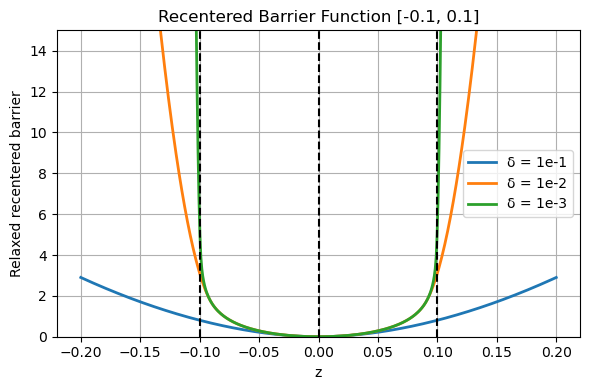

In [ ]:
## --------- RELAXED RECENTERED BARRIER FUNCTION FOR Δu CONSTRAINTS --------- ##

def barrier_du(z, z_min, z_max, delta):
    """
    Computes a relaxed, recentered barrier penalty to softly enforce:
        z_min <= z <= z_max

    This function is useful for applying smooth penalties on Δu (or other constrained variables)
    to discourage violations of specified bounds using a differentiable approximation.

    Args:
        z (Tensor): Quantity to penalize (can be scalar or tensor).
        z_min (float): Lower bound.
        z_max (float): Upper bound.
        delta (float): Positive relaxation parameter (controls smoothness near boundaries).

    Returns:
        B_rec (Tensor): Relaxed and recentered barrier penalty.
    """
    # Convert bounds and delta to tensors matching z's device and dtype
    z_min_t = torch.tensor(z_min, device=z.device, dtype=z.dtype)
    z_max_t = torch.tensor(z_max, device=z.device, dtype=z.dtype)
    delta_t = torch.tensor(delta, device=z.device, dtype=z.dtype)

    def B_single(x, delta):
        """
        Relaxed single-sided barrier.
        For x > delta:      -log(x)
        For x <= delta:     quadratic smoothing
        """
        return torch.where(
            x > delta,
            -torch.log(x),
            0.5 * ((x - 2 * delta) / delta) ** 2 - 0.5 - torch.log(delta)
        )

    # Apply single-sided barrier to both bounds
    B_raw = B_single(z - z_min_t, delta_t) + B_single(z_max_t - z, delta_t)

    # Recenter barrier so minimum penalty is zero (at midpoint)
    z_c = 0.5 * (z_min_t + z_max_t)
    B_center = B_single(z_c - z_min_t, delta_t) + B_single(z_max_t - z_c, delta_t)
    B_rec = B_raw - B_center

    return B_rec

# -------------------------------- Demo ---------------------------------------#
z_min, z_max = -0.1, 0.1
z = torch.linspace(-0.2, 0.2, 500)

B_1 = barrier_du(z, z_min, z_max, 1e-1)
B_2 = barrier_du(z, z_min, z_max, 1e-2)
B_3 = barrier_du(z, z_min, z_max, 1e-3)

plt.figure(figsize=(6, 4))
plt.plot(z.numpy(), B_1.numpy(), lw=2)
plt.plot(z.numpy(), B_2.numpy(), lw=2)
plt.plot(z.numpy(), B_3.numpy(), lw=2)
plt.legend(['δ = 1e-1', 'δ = 1e-2', 'δ = 1e-3'])
plt.ylim(0, 15)
plt.axvline(z_min, color='k', ls='--')
plt.axvline(z_max, color='k', ls='--')
plt.axvline(0.0, color='k', ls='--')
plt.xlabel('z'); plt.ylabel('Relaxed recentered barrier')
plt.title(f'Recentered Barrier Function [{z_min}, {z_max}]')
plt.grid(True); plt.tight_layout(); plt.show()

### Basic Functions

In [ ]:
## ---------------------- PINN-MPC CONTROLLER MODULE ------------------------ ##

class PINN_Controller(nn.Module):
    """
    PINN-MPC controller for a nonlinear water tank system.

    Predicts trajectories h(t), u(t) that satisfy dynamics and constraints,
    using physics-informed neural networks.

    Inputs:  [t, h0, u0, h_set, d0, h0 - h_set]
    Outputs: [h(t), u(t)]

    Constraints:
        h ∈ [0, 3] m,
        u ∈ [0, 1] m³/s,
        Δu ∈ [−0.2, 0.2] m³/s
    """

    def __init__(self, hidden_layers: List[int] = [64, 16, 16]):
        super().__init__()
        self.h_min, self.h_max = 0.0, 3.0
        self.u_min, self.u_max = 0.0, 1.0
        self.du_max = 0.2

        self.mean_trk_final_history = []

        self.register_buffer('last_h', torch.zeros(1))
        self.register_buffer('last_u', torch.zeros(1))
        self.register_buffer('last_hsp', torch.zeros(1))
        self.register_buffer('last_d0', torch.zeros(1))

        # Build neural network
        layers = []
        in_dim = 6  # [t, h0, u0, h_set, d0, e]
        for width in hidden_layers:
            layers += [nn.Linear(in_dim, width), nn.Tanh()]
            in_dim = width
        layers += [nn.Linear(in_dim, 2)]  # output: h_pred, u_pred
        self.net = nn.Sequential(*layers)

    def forward(self, t, h0, u0, h_set, d0):
        x = torch.stack((t, h0, u0, h_set, d0, h0 - h_set), dim=-1)
        h_pred, u_pred = self.net(x).unbind(-1)
        return h_pred, u_pred

    def loss(self, bs, t_wp, N_WP, t_col, N_COL, h0, u0, h_set, d0,
             w_ode, w_trk, w_utrk, w_du, w_u, w_h, w_h0):
        """
        Computes total loss for training the PINN-MPC.

        Returns:
            loss_total: scalar
            (loss_pde, loss_trk, loss_utrk, loss_du, loss_u, loss_h, loss_h0): individual components
        """
        # ─────────────────────── Forward pass on t_wp ────────────────────────
        t_wp = t_wp.clone().detach().requires_grad_(True)
        t_flat = t_wp.repeat(bs)

        h0_flat = h0.repeat_interleave(N_WP)         # (bs*N_WP,)
        u0_flat = u0.repeat_interleave(N_WP)
        hs_flat = h_set.repeat_interleave(N_WP)
        d0_flat = d0.repeat_interleave(N_WP)

        h_flat, u_flat = self(t_flat, h0_flat, u0_flat, hs_flat, d0_flat)
        h = h_flat.view(bs, N_WP)   # (bs, N_WP)
        u = u_flat.view(bs, N_WP)   # (bs, N_WP)

        # ─────────────────────── Forward pass on t_col ────────────────────────
        t_col = t_col.clone().detach().requires_grad_(True)
        t_flat_col = t_col.repeat(bs)

        h0_flat_col = h0.repeat_interleave(N_COL)    # (bs*N_COL,)
        u0_flat_col = u0.repeat_interleave(N_COL)
        hs_flat_col = h_set.repeat_interleave(N_COL)
        d0_flat_col = d0.repeat_interleave(N_COL)

        h_flat_col, u_flat_col = self(t_flat_col, h0_flat_col, u0_flat_col, hs_flat_col, d0_flat_col)
        h_col = h_flat_col.view(bs, N_COL)           # (bs, N_COL)
        u_col = u_flat_col.view(bs, N_COL)           # (bs, N_COL)

        # ─────────────────────────── PDE Residual Loss ───────────────────────────
        dh_dt_flat = grad(h_flat_col, t_flat_col,
                          torch.ones_like(h_flat_col),
                          create_graph=True)[0]
        dh_dt = dh_dt_flat.view(bs, N_COL)           # (bs, N_COL)
        fout = self.K_VALVE * torch.sqrt(torch.clamp(h_col, min=0.0))
        d0_mat = d0.unsqueeze(1)                     # (bs, 1) → broadcast
        r_pde = dh_dt - (u_col + d0_mat - fout) / self.A  # (bs, N_COL)
        sq_pde = (1 / N_COL) * r_pde.pow(2).sum(dim=1)  # (bs,)
        loss_pde = w_ode * sq_pde.mean()               # scalar

        # ───────────────────────────── Tracking Loss ─────────────────────────────
        hset_mat = h_set.unsqueeze(1)                  # (bs, 1)
        e_trk = h - hset_mat                           # (bs, N_WP)
        sq_trk = (1 / N_WP) * e_trk.pow(2).sum(dim=1)  # (bs,)
        loss_trk = w_trk * sq_trk.mean()               # scalar

        # ───────────────────── Steady-State Control Tracking ─────────────────────
        u_ss = self.K_VALVE * torch.sqrt(hset_mat) - d0_mat     # (bs, 1)
        u_trk = u - u_ss                                    # (bs, N_WP)
        sq_utrk = (1 / N_WP) * u_trk.pow(2).sum(dim=1)      # (bs,)
        loss_utrk = w_utrk * sq_utrk.mean()                 # scalar

        # ─────────────────────── Δu Barrier Loss ──────────────────────────
        delta = 0.01
        u_seq = torch.cat([u0.unsqueeze(1), u], dim=1)      # (bs, N_WP+1)
        Δu = u_seq[:, 1:] - u_seq[:, :-1]                   # (bs, N_WP)
        bu = barrier_du(Δu, -self.du_max, self.du_max, delta)  # (bs, N_WP)
        sq_bdu = (1 / N_WP) * bu.sum(dim=1)                 # (bs,)
        loss_du = w_du * sq_bdu.mean()                      # scalar

        # ─────────────────────── Soft Bounds on u(t) ──────────────────────
        e_min_u = F.relu(self.u_min - u)                    # (bs, N_WP)
        e_max_u = F.relu(u - self.u_max)                    # (bs, N_WP)
        slack_u = e_min_u + e_max_u                         # (bs, N_WP)
        sum_slack_u = (1 / N_WP) * slack_u.sum(dim=1)       # (bs,)
        loss_u = w_u * sum_slack_u.pow(2).mean()            # scalar

        # ─────────────────────── Soft Bounds on h(t) ──────────────────────
        e_min_h = F.relu(self.h_min - h)                    # (bs, N_WP)
        e_max_h = F.relu(h - self.h_max)                    # (bs, N_WP)
        slack_h = e_min_h + e_max_h                         # (bs, N_WP)
        sum_slack_h = (1 / N_WP) * slack_h.sum(dim=1)       # (bs,)
        loss_h = w_h * sum_slack_h.pow(2).mean()            # scalar

        # ─────────────────────── Initial Condition Loss ──────────────────────
        h0_col = h0.unsqueeze(1)                            # (bs, 1)
        h0_pred = h[:, 0:1]                                 # (bs, 1)
        sq_h0 = (h0_pred - h0_col).pow(2)                   # (bs, 1)
        loss_h0 = w_h0 * sq_h0.mean()                       # scalar

        # ─────────────────────── Final Error (for logging) ──────────────────────
        final_err = e_trk[:, -1].abs().mean()               # scalar
        self.mean_trk_final_history.append(final_err.item())

        # ─────────────────────── Cache Last Batch ──────────────────────
        self.last_h = h.detach()
        self.last_u = u.detach()
        self.last_hsp = h_set.detach()
        self.last_d0 = d0.detach()

        # ─────────────────────── Total Loss ──────────────────────
        loss_total = loss_pde + loss_trk + loss_utrk + loss_du + loss_u + loss_h + loss_h0
        return loss_total, (loss_pde, loss_trk, loss_utrk, loss_du, loss_u, loss_h, loss_h0)


In [ ]:
## ----------------------- PINN-MPC TRAINING SCHEDULE ----------------------- ##

def train_PINN(T_INTERVAL, Ts, model, K1, K2, zero_ratio,
               bs1=256*10, bs2=256*10,
               lr1=1e-3, lr2=1e-4,
               w_ode=250.0, w_trk=200.0, w_utrk=250.0,
               w_du=2.0, w_u=0.0, w_h=0.0, w_h0=850.0):
    """
    Two-phase training loop for PINN-MPC controller using Adam optimizer.

    Phase 1: Physics + tracking + IC (Δu, bounds off)
    Phase 2: Full loss (adds Δu suppression and soft bounds)

    Args:
        T_INTERVAL (float): Prediction horizon [s]
        Ts (float): Control sampling time [s]
        model (nn.Module): PINN-MPC controller
        K1 (int): Epochs in Phase 1
        K2 (int): Epochs in Phase 2
        zero_ratio (float): % of samples with d0 = 0
        bs1, bs2 (int): Batch sizes
        lr1, lr2 (float): Learning rates for each phase
        w_rpde, w_trk, w_utrk (float): Weights for PDE and tracking terms
        w_du, w_u, w_h, w_h0 (float): Weights for Δu, bounds, and IC terms

    Returns:
        hist (list of float): Loss history over epochs
    """
    scaler = torch.amp.GradScaler()
    hist = []

    # Create time vectors
    t_wp = torch.cat([torch.arange(0, T_INTERVAL, Ts, device=DEVICE),
                      torch.tensor([T_INTERVAL], device=DEVICE)])
    N_WP = t_wp.shape[0]

    t_col = generate_collocation_points(horizon=T_INTERVAL,
                                        dt_dense=0.01, dt_medium=0.1, dt_sparse=1.0)
    N_COL = t_col.shape[0]

    # Sample one giant batch for Phase 1 (will slice per epoch)
    B1 = bs1 * K1
    h0_all, u0_all, hset_all, d0_all = sample_batch(B1, K_VALVE = 0.7, zero_ratio = zero_ratio)

    ## ---------------------- Phase 1: Adam (no bounds) --------------------- ##
    print("Phase 1: Adam")
    opt_adam = torch.optim.Adam(model.parameters(), lr=lr1)

    for ep in range(1, K1 + 1):
        start = (ep - 1) * bs1
        h0 = h0_all[start:start + bs1]
        u0 = u0_all[start:start + bs1]
        h_set = hset_all[start:start + bs1]
        d0 = d0_all[start:start + bs1]

        with torch.amp.autocast(device_type="cuda"):
            loss, detail = model.loss(bs1, t_wp, N_WP, t_col, N_COL,
                                      h0, u0, h_set, d0,
                                      w_ode, w_trk, w_utrk,
                                      0.0, 0.0, 0.0, w_h0)

        if torch.isnan(loss):
            print("Loss is nan, terminating training")
            break

        opt_adam.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt_adam)
        scaler.update()

        hist.append(loss.item())

        if ep == 1 or ep % 500 == 0 or ep == K1:
            print_loss(ep, loss, *detail)

    ## ---------------------- Phase 2: Adam (full loss) --------------------- ##
    if K2 == 0:
        print("Training stopped after Phase 1.")
        return hist

    print("Phase 2: Adam")
    opt_adam = torch.optim.Adam(model.parameters(), lr=lr2)

    for ep in range(1, K2 + 1):
        start = (ep - 1) * bs2
        h0 = h0_all[start:start + bs2]
        u0 = u0_all[start:start + bs2]
        h_set = hset_all[start:start + bs2]
        d0 = d0_all[start:start + bs2]

        with torch.amp.autocast(device_type="cuda"):
            loss, detail = model.loss(bs2, t_wp, N_WP, t_col, N_COL,
                                      h0, u0, h_set, d0,
                                      w_ode, w_trk, w_utrk,
                                      w_du, w_u, w_h, w_h0)

        if torch.isnan(loss):
            print("Loss is nan, terminating training")
            break

        opt_adam.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt_adam)
        scaler.update()

        hist.append(loss.item())

        if ep == 1 or ep % 500 == 0 or ep == K2:
            print_loss(ep, loss, *detail)

    return hist


## ------------------------- LOSS COMPONENT PROGRESS ------------------------ ##

def print_loss(ep, loss, loss_pde, loss_trk, loss_utrk, loss_du, loss_u, loss_h, loss_h0):
    """
    Prints loss breakdown for diagnostics.
    """
    print(f"Epoch {ep:4d} | "
          f"Total: {loss:.4e} | "
          f"ODE: {loss_pde:.2e} | "
          f"Track hsp: {loss_trk:.2e} | "
          f"Track u: {loss_utrk:.2e} | "
          f"Δu: {loss_du:.2e} | "
          f"u bounds: {loss_u:.2e} | "
          f"h bounds: {loss_h:.2e} | "
          f"h IC: {loss_h0:.2e}")

### Training Procedure

In [ ]:
## ----------------------------- TRAIN PINN-MPC ------------------------------ ##

# Set seed for reproducibility and clear CUDA memory
torch.manual_seed(0)
torch.cuda.empty_cache()

# Instantiate PINN-MPC controller model
model = PINN_Controller(hidden_layers=[64, 16, 16]).to(DEVICE)  # Architecture: [input → 64 → 16 → 16 → output]

# Define system parameters
model.K_VALVE = 0.7 # Outflow coefficient (m².⁵/s)
model.A = 1.0 # Tank cross-sectional area (m²)

# Print number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters in model: {trainable_params}")

# Set training configuration
T_INTERVAL   = 25.0   # Prediction horizon [s]
Ts           = 1.0    # Control sampling time [s]
K1, K2       = 5000, 5000   # Epochs in Phase 1 and 2
zero_ratio   = 0.2          # % of samples with zero disturbance

# Train the PINN-MPC controller (2-phase Adam schedule)
start_time = time.time()
loss_history = train_PINN(
    T_INTERVAL, Ts, model, K1, K2, zero_ratio,
    bs1=1000, bs2=1000,
    lr1=6.871209468055223e-05, lr2=0.002166560286589728,
    w_ode=131.2036331073741,   # ODE residual
    w_trk=6.281902184510784,   # h tracking
    w_utrk=6.72820755280816,   # u tracking
    w_du=32.5,                 # Δu penalty
    w_u=3250.0,                # u bound penalty
    w_h=325.0,                 # h bound penalty
    w_h0=2.3417227078047818    # h initial condition
)

end_time = time.time()
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

Total number of trainable parameters in model: 1794
Phase 1: Adam
Epoch    1 | Total: 1.0645e+01 | ODE: 2.57e+00 | Track hsp: 5.16e+00 | Track u: 9.35e-01 | Δu: 0.00e+00 | u bounds: 0.00e+00 | h bounds: 0.00e+00 | h IC: 1.99e+00
Epoch  500 | Total: 5.0437e+00 | ODE: 2.05e+00 | Track hsp: 1.93e+00 | Track u: 3.72e-01 | Δu: 0.00e+00 | u bounds: 0.00e+00 | h bounds: 0.00e+00 | h IC: 6.89e-01
Epoch 1000 | Total: 2.7497e+00 | ODE: 8.72e-01 | Track hsp: 1.15e+00 | Track u: 1.97e-01 | Δu: 0.00e+00 | u bounds: 0.00e+00 | h bounds: 0.00e+00 | h IC: 5.32e-01
Epoch 1500 | Total: 7.4117e-01 | ODE: 1.38e-01 | Track hsp: 3.31e-01 | Track u: 3.92e-02 | Δu: 0.00e+00 | u bounds: 0.00e+00 | h bounds: 0.00e+00 | h IC: 2.33e-01
Epoch 2000 | Total: 5.1176e-01 | ODE: 8.65e-02 | Track hsp: 2.72e-01 | Track u: 2.20e-02 | Δu: 0.00e+00 | u bounds: 0.00e+00 | h bounds: 0.00e+00 | h IC: 1.31e-01
Epoch 2500 | Total: 3.9648e-01 | ODE: 6.00e-02 | Track hsp: 2.30e-01 | Track u: 1.57e-02 | Δu: 0.00e+00 | u bounds: 0.0

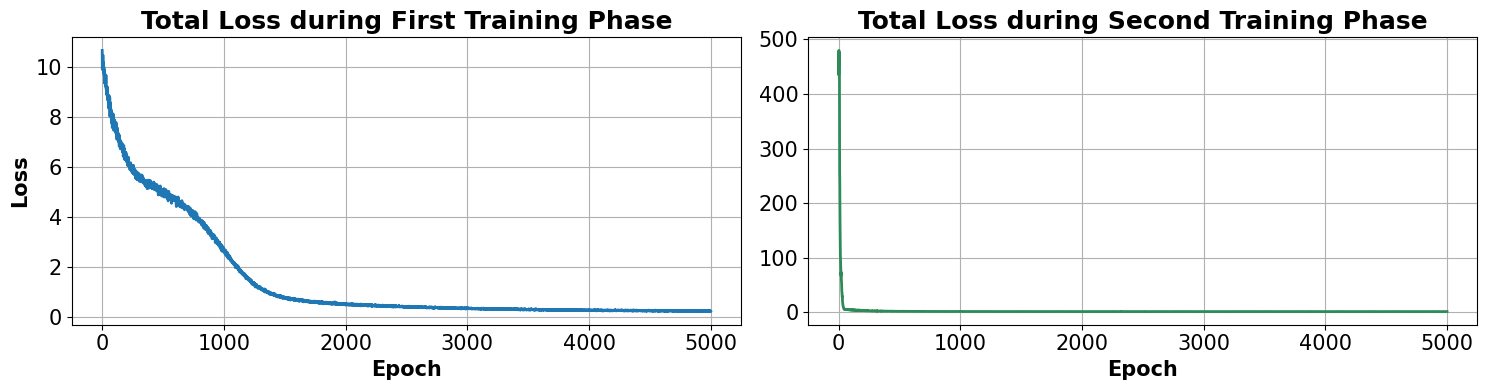

In [ ]:
## -------------- PLOT LOSS EVOLUTION FOR EACH TRAINING PHASE --------------- ##

# Visualize training loss across both optimization phases
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Phase 1 loss
ax1.plot(loss_history[:K1], linewidth=2)
ax1.set_title("Total Loss during First Training Phase", fontsize=18, fontweight='bold')
ax1.set_xlabel("Epoch", fontsize=15, fontweight='bold')
ax1.set_ylabel("Loss", fontsize=15, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.grid(True)

# Phase 2 loss
ax2.plot(loss_history[K1:], linewidth=2, color="seagreen")
ax2.set_title("Total Loss during Second Training Phase", fontsize=18, fontweight='bold')
ax2.set_xlabel("Epoch", fontsize=15, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.grid(True)

plt.tight_layout()
plt.show()

## PINN-MPC Validation

### Functions

In [ ]:
## ------------- TEST GRID OF INITIAL CONDITIONS FOR PINN-MPC --------------- ##

def initialize_test_grid_dist(N_h: int = 20, N_d: int = 5,
                              d_min: float = 0.0, d_max: float = 0.4,
                              delta_h_min: float = 0.1,
                              h_min: float = 0.0, h_max: float = 0.0,
                              K_valve: float = 0.7,
                              device: str = 'cpu'):
    """
    Builds a grid of (h0, h_set, d0) for evaluating the PINN-MPC controller.

    Excludes:
      • Cases where |h0 − h_set| < delta_h_min (insignificant transitions)
      • Cases where h_set is not physically reachable given d0 and max inflow

    Args:
        N_h (int): Number of points for h0 and h_set each.
        N_d (int): Number of disturbance values.
        d_min (float): Minimum disturbance (m³/s).
        d_max (float): Maximum disturbance (m³/s).
        delta_h_min (float): Minimum required setpoint change (m).
        h_min (float): Minimum tank level (m).
        h_max (float): Maximum tank level (m). If 0, inferred from PDE.
        K_valve (float): Valve coefficient (m².⁵/s).
        device (str): Device to place the tensors on ('cpu' or 'cuda').

    Returns:
        h0_grid (Tensor): Initial levels [N] (m).
        hsp_grid (Tensor): Setpoints [N] (m).
        d0_grid (Tensor): Disturbances [N] (m³/s).
    """
    # If h_max is not given, use the theoretical max achievable height
    if h_max == 0.0:
        h_max = (1.0 / K_valve) ** 2

    # Generate evenly spaced values
    h0_vals = torch.linspace(h_min, h_max, N_h, device=device)
    hsp_vals = torch.linspace(h_min, h_max, N_h, device=device)
    d0_vals = torch.linspace(d_min, d_max, N_d, device=device)

    # Create full 3D grid
    H0, HSP, D0 = torch.meshgrid(h0_vals, hsp_vals, d0_vals, indexing='ij')

    # Flatten the grid to (N,) vectors
    h0_grid = H0.flatten()
    hsp_grid = HSP.flatten()
    d0_grid = D0.flatten()

    # Compute feasibility bounds from system dynamics
    hsp_min = (d0_grid / K_valve) ** 2  # min achievable h_set (u = 0)
    hsp_max = h_max                    # max achievable h_set (u = 1, simplified)

    # Build a mask for valid test cases
    mask = (h0_grid - hsp_grid).abs() >= delta_h_min
    mask &= hsp_grid >= hsp_min
    mask &= hsp_grid <= hsp_max

    # Filter infeasible cases
    h0_grid = h0_grid[mask]
    hsp_grid = hsp_grid[mask]
    d0_grid = d0_grid[mask]

    print(f"Evaluating on {h0_grid.numel()} valid test cases…")

    return h0_grid, hsp_grid, d0_grid

In [ ]:
## ----------- CLOSED-LOOP SINGLE TRAJECTORY SIMULATION (PINN-MPC) ---------- ##

def rollout(model, h_init=0.2, h_set=1.0, u_init=0.0, d0=0.0,
            K_VALVE=0.7, A=1.0, dt=0.01, Ts=1.0, noise=0.0,
            simulation_time=T_INTERVAL, sp_change=5.0, d_step=30.0):
    """
    Simulates a single closed-loop trajectory of the nonlinear water tank system
    using the PINN-MPC controller.

    Args:
        model: Trained PINN-MPC controller.
        h_init (float): Initial tank level (m).
        h_set (float): Final setpoint after sp_change time (m).
        u_init (float): Initial inflow rate (m³/s).
        d0 (float): Constant disturbance inflow (m³/s).
        K_VALVE (float): Valve coefficient (m².⁵/s).
        A (float): Cross-sectional area of the tank (m²).
        dt (float): Internal simulation time step (s).
        Ts (float): Controller sampling time (s).
        noise (float): Std dev of measurement noise on h (m).
        simulation_time (float): Total simulation duration (s).
        sp_change (float): Time when setpoint switches to h_set (s).
        d_step (float): Time when disturbance d0 is applied (s).

    Returns:
        t_hist (Tensor): Time history (s).
        h_hist (Tensor): Tank level history (m).
        u_hist (Tensor): Control input history (m³/s).
        hsp_hist (Tensor): Setpoint history (m).
        d_hist (Tensor): Disturbance history (m³/s).
    """
    query_step = Ts
    steps = int(simulation_time / query_step)

    h = torch.tensor([h_init], device=DEVICE, dtype=torch.float)
    h_net = h + torch.randn_like(h) * noise
    d0_base = torch.tensor([d0], device=DEVICE, dtype=torch.float)
    d0_curr = d0_base

    t_hist, h_hist, u_hist, hsp_hist, d_hist = [], [], [], [], []
    t_curr = 0.0

    u_prev = torch.tensor([K_VALVE * math.sqrt(max(h_init, 0.0))],
                          device=DEVICE, dtype=torch.float)

    for _ in range(steps):
        h_set_tensor = torch.tensor(
            [h_init if t_curr < sp_change else h_set],
            device=DEVICE, dtype=torch.float)

        d0_curr = d0_base * (1.0 if t_curr >= d_step else 0.0)

        # Query the PINN-MPC controller
        h_pred_next, u_pred = model(torch.tensor([query_step], device=DEVICE),
                                    h_net, u_prev, h_set_tensor, d0_curr)

        u_cmd = u_pred.item()

        # Simulate inner dynamics using fine steps
        h_curr = h.item()
        n_inner = int(query_step / dt)

        for _ in range(n_inner):
            dh = (u_cmd + d0_curr.item() - K_VALVE * math.sqrt(max(h_curr, 0.0))) / A
            h_curr = max(h_curr + dh * dt, 0.0)

            t_curr += dt
            t_hist.append(t_curr)
            h_hist.append(h_curr)
            u_hist.append(u_cmd)
            hsp_hist.append(h_set_tensor.item())
            d_hist.append(d0_curr.item())

        h = torch.tensor([h_curr], device=DEVICE, dtype=torch.float)
        h_net = h + torch.randn_like(h) * noise
        u_prev = torch.tensor([u_cmd], device=DEVICE, dtype=torch.float)

    return (
        torch.tensor(t_hist, device=DEVICE),
        torch.tensor(h_hist, device=DEVICE),
        torch.tensor(u_hist, device=DEVICE),
        torch.tensor(hsp_hist, device=DEVICE),
        torch.tensor(d_hist, device=DEVICE))

## --- PARALLEL CLOSED-LOOP SIMULATION OVER MULTIPLE INSTANCES (PINN-MPC) --- ##

def rollout_batch(model, h0, hsp_target, u0, d0,
                  K_VALVE=0.7, A=1.0, dt=0.01, Ts=1.0, noise=0.0,
                  simulation_time=T_INTERVAL, sp_change=5.0, d_step=30.0):
    """
    Simulates multiple water tank systems in parallel using the PINN-MPC controller.

    Args:
        model: Trained PINN-MPC controller.
        h0 (Tensor): Initial tank levels [B] (m).
        hsp_target (Tensor): Target setpoints [B] (m).
        u0 (Tensor or None): Initial inflow rates [B] (m³/s).
        d0 (Tensor): Constant disturbances [B] (m³/s).
        K_VALVE (float): Valve coefficient (m².⁵/s).
        A (float): Tank cross-sectional area (m²).
        dt (float): Internal plant integration step (s).
        Ts (float): Controller sampling interval (s).
        noise (float): Std dev of measurement noise on h (m).
        simulation_time (float): Total duration (s).
        sp_change (float): Time when setpoint switches from h0 to hsp_target (s).
        d_step (float): Time when disturbance is applied (s).

    Returns:
        t_hist (Tensor): Time vector [N].
        h_hist (Tensor): Tank level trajectories [B, N] (m).
        u_hist (Tensor): Control input trajectories [B, N] (m³/s).
        hsp_hist (Tensor): Setpoint trajectories [B, N] (m).
        d_hist (Tensor): Disturbance trajectories [B, N] (m³/s).
    """
    bs = h0.shape[0]
    query_step = Ts
    n_query_steps = int(simulation_time / query_step)
    n_inner = int(query_step / dt)

    h_curr = h0.clone().to(DEVICE)
    h_net = h_curr + torch.randn_like(h_curr) * noise
    u_prev = u0.to(DEVICE) if u0 is not None else K_VALVE * torch.sqrt(h_curr.clamp(min=0.0))
    d0 = d0.to(DEVICE)

    hsp_init_tensor = h0.clone().to(DEVICE)

    t_hist_list, h_hist_list, u_hist_list = [], [], []
    hsp_hist_list, d_hist_list = [], []
    t_curr_scalar = 0.0

    for _ in range(n_query_steps):
        hsp_k = hsp_init_tensor if t_curr_scalar < sp_change else hsp_target.to(DEVICE)
        d_k = torch.zeros_like(d0) if t_curr_scalar < d_step else d0

        query_dt = torch.full((bs, 1), query_step, device=DEVICE)
        h_pred_next, u_pred = model(query_dt, h_net.unsqueeze(-1),
                                    u_prev.unsqueeze(-1), hsp_k.unsqueeze(-1),
                                    d_k.unsqueeze(-1))

        u_cmd = u_pred.squeeze(-1)
        h_inner = h_curr.clone()

        for _ in range(n_inner):
            dh = (u_cmd + d_k - K_VALVE * torch.sqrt(h_inner.clamp(min=0.0))) / A
            h_inner = (h_inner + dh * dt).clamp(min=0.0)
            t_curr_scalar += dt

            t_hist_list.append(t_curr_scalar)
            h_hist_list.append(h_inner.cpu())
            u_hist_list.append(u_cmd.cpu())
            hsp_hist_list.append(hsp_k.cpu())
            d_hist_list.append(d_k.cpu())

        h_curr = h_inner.clone()
        h_net = h_curr + torch.randn_like(h_curr) * noise
        u_prev = u_cmd.clone()

    t_hist = torch.tensor(t_hist_list, device=DEVICE)
    h_hist = torch.stack(h_hist_list, dim=1).to(DEVICE)
    u_hist = torch.stack(u_hist_list, dim=1).to(DEVICE)
    hsp_hist = torch.stack(hsp_hist_list, dim=1).to(DEVICE)
    d_hist = torch.stack(d_hist_list, dim=1).to(DEVICE)

    return t_hist, h_hist, u_hist, hsp_hist, d_hist

In [ ]:
## -------------------- EVALUATE PINN-MPC ON TEST CASES --------------------- ##

@torch.no_grad()
def evaluate_model_parallel_dist(model, h0_grid, hsp_grid, d0_grid,
                                 K_VALVE=0.7, A=1.0, dt=0.01, Ts=1.0,
                                 noise=0.0, simulation_time=T_INTERVAL,
                                 sp_change=5.0, d_step=30.0):
    """
    Evaluates the PINN-MPC controller on a batch of test cases, computing final error metrics.

    Two modes:
      • Set-point tracking → set sp_change > 0, d_step = 0
      • Disturbance rejection → set sp_change = 0, d_step > 0

    Args:
        model: Trained PINN-MPC controller (torch.nn.Module).
        h0_grid (Tensor): Initial tank levels [B] (m).
        hsp_grid (Tensor): Setpoints [B] (m).
        d0_grid (Tensor): Disturbance values [B] (m³/s).
        K_VALVE (float): Valve coefficient (m².⁵/s).
        A (float): Tank cross-sectional area (m²).
        dt (float): Inner simulation time step (s).
        Ts (float): Sampling interval for the controller (s).
        noise (float): Std dev of measurement noise on h (m).
        simulation_time (float): Duration of each trajectory (s).
        sp_change (float): Time when setpoint switches to hsp (s).
        d_step (float): Time when disturbance is applied (s).

    Returns:
        dict with:
            final_sse (Tensor): Final signed steady-state error (m) [B]
            final_sse_abs (Tensor): Final absolute error (m) [B]
            final_perc (Tensor): Final relative error (%) [B]
            max_final_error (float): Max absolute error (m)
            min_final_error (float): Min absolute error (m)
            max_perc_error (float): Max relative error (%)
            mean_abs_error (float): Mean absolute error (m)
    """
    model.eval()

    # Transfer to device
    h0 = h0_grid.to(DEVICE)
    hsp = hsp_grid.to(DEVICE)
    d0 = d0_grid.to(DEVICE)

    # Roll out trajectories in parallel using the PINN-MPC
    t, H, U, _, _ = rollout_batch(
        model, h0, hsp, None, d0,
        K_VALVE=K_VALVE, A=A, dt=dt, Ts=Ts, noise=noise,
        simulation_time=simulation_time,
        sp_change=sp_change, d_step=d_step
    )

    # Transfer outputs to CPU for metric computation
    t = t.cpu()
    H = H.cpu()
    U = U.cpu()
    hsp_cpu = hsp.cpu()

    # Compute final error metrics at end of simulation
    final_sse = H[:, -1] - hsp_cpu                         # Signed error (m)
    final_perc = final_sse / hsp_cpu.clamp(min=1e-6) * 100 # Relative error (%)

    return {
        "final_sse":       final_sse,
        "final_sse_abs":   final_sse.abs(),
        "final_perc":      final_perc,
        "max_final_error": final_sse.abs().max().item(),
        "min_final_error": final_sse.abs().min().item(),
        "max_perc_error":  final_perc.max().item(),
        "mean_abs_error":  final_sse.abs().mean().item()}

In [ ]:
## ------------------ MULTI-CASE INFERENCE PINN-MPC PLOTS ------------------- ##

def evaluate_multi_case(model,
                        h0_test: float, u0_test: float,
                        hsp_list: Sequence[float], d0_list: Sequence[float],
                        K_VALVE: float = 0.7, A: float = 1.0,
                        dt: float = 0.01, Ts: float = 1.0,
                        noise: float = 0.0,
                        simulation_time: float = 20.0,
                        d_step: float = 30.0,
                        shift_time: float = 0.0,
                        plot_disturbance: bool = True,
                        ylimits = 'auto'):
    """
    Runs back-to-back rollouts (each of length `simulation_time`) for each
    (h_set, d0) pair in hsp_list and d0_list using the PINN-MPC controller.
    For each segment:
      • The set-point is updated immediately (sp_change = 0).
      • The disturbance is reset for each segment.
      • Only the final (h, u) from the segment are carried forward to the next.

    Args:
        model: Trained PINN-MPC controller.
        h0_test (float): Initial tank level for the test (m).
        u0_test (float): Initial control input for the test (m³/s).
        hsp_list (Sequence[float]): List of setpoints (m).
        d0_list (Sequence[float]): List of disturbance values (m³/s).
                                  Must be the same length as hsp_list.
        K_VALVE (float): Valve coefficient (m².⁵/s).
        A (float): Tank cross-sectional area (m²).
        dt (float): Fine simulation time step (s).
        Ts (float): PINN-MPC sampling time (s).
        noise (float): Std dev of measurement noise (m).
        simulation_time (float): Duration of each rollout segment (s).
        d_step (float): Time when the disturbance is activated (s).
        shift_time (float): Time (s) to shift the time axis for plotting.
        plot_disturbance (bool): Whether to plot the disturbance signal.
        ylimits: y-axis limits (tuple) for the plant output plot, or 'auto'.

    Returns:
        None. Generates two plots:
            1. Full trajectory plot of h(t), u(t), and d(t) (if enabled).
            2. A zoomed-in plot of the final segment.
    """
    # Ensure hsp_list and d0_list have the same length
    assert len(hsp_list) == len(d0_list), "hsp_list and d0_list must have the same length"

    # Storage for data from each segment
    t_segs, h_segs, u_segs, hsp_segs, d_segs = [], [], [], [], []

    # Initial conditions
    h_init, u_init = h0_test, u0_test

    # Process each segment sequentially
    for i, (hsp_seg, d0_seg) in enumerate(zip(hsp_list, d0_list)):
        # One rollout with immediate SP change (sp_change=0) and new disturbance d0_seg
        t, h_hist, u_hist, hsp_hist, d_hist = rollout(
            model, h_init=h_init, h_set=hsp_seg, u_init=u_init, d0=d0_seg,
            K_VALVE=K_VALVE, A=A, dt=dt, Ts=Ts, noise=noise,
            simulation_time=simulation_time, sp_change=0.0, d_step=d_step
        )

        # Convert tensors to NumPy arrays and offset the time axis for stacking
        t_np   = t.cpu().numpy() + i * simulation_time
        h_np   = h_hist.cpu().numpy()
        u_np   = u_hist.cpu().numpy()
        hsp_np = hsp_hist.cpu().numpy()
        d_np   = d_hist.cpu().numpy()

        # Omit duplicate join point (except for the first segment)
        if i > 0:
            t_np, h_np, u_np, hsp_np, d_np = (arr[1:] for arr in (t_np, h_np, u_np, hsp_np, d_np))

        # Collect segment data
        t_segs.append(t_np)
        h_segs.append(h_np)
        u_segs.append(u_np)
        hsp_segs.append(hsp_np)
        d_segs.append(d_np)

        # Carry forward only the final state values from this segment
        h_init = h_np[-1]
        u_init = u_np[-1]

    # Stitch segments together into full trajectories
    t_full   = np.concatenate(t_segs)
    h_full   = np.concatenate(h_segs)
    u_full   = np.concatenate(u_segs)
    hsp_full = np.concatenate(hsp_segs)
    d_full   = np.concatenate(d_segs)

    # Compute final error against the last setpoint
    final_err  = h_full[-1] - hsp_list[-1]
    final_perc = (final_err / hsp_list[-1] * 100) if hsp_list[-1] != 0 else 0.0
    print(f"--- Final error: {final_err:.4f} m ({final_perc:.2f} %) ---")

    # Apply time shift if requested
    if shift_time > 0:
        mask     = t_full >= shift_time
        t_plot   = t_full[mask] - shift_time
        h_plot   = h_full[mask]
        hsp_plot = hsp_full[mask]
        u_plot   = u_full[mask]
        d_plot   = d_full[mask]
    else:
        t_plot, h_plot, hsp_plot, u_plot, d_plot = t_full, h_full, hsp_full, u_full, d_full

    # Set up the plot dimensions
    n_rows = 3 if plot_disturbance else 2
    fig, axes = plt.subplots(n_rows, 1, figsize=(15.0, 3.5 * n_rows), sharex=True)

    if plot_disturbance:
        ax_h, ax_u, ax_d = axes
    else:
        ax_h, ax_u = axes

    # --- h(t): Plant Output vs Setpoint ---
    ax_h.plot(t_plot, h_plot, color='black', linewidth=4.5, label=r"$h(t)$")
    ax_h.plot(t_plot, hsp_plot, '--', color='red', linewidth=4.5, label=r"$h_{\mathrm{sp}}$")
    ax_h.set_ylabel("Tank Level (m)", fontsize=20)
    ax_h.set_xlim([t_plot[0], t_plot[-1]])
    ax_h.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_h.tick_params(labelsize=18)
    ax_h.legend(loc='best', fontsize=20)
    ax_h.set_title("Controlled Output", fontsize=22, fontweight='bold')
    ax_h.yaxis.set_major_locator(MultipleLocator(0.3))
    if ylimits != 'auto':
        ax_h.set_ylim(ylimits)

    # --- u(t): Control Signal ---
    ax_u.plot(t_plot, u_plot, color='steelblue', linewidth=4.5, label=r"$u(t)$")
    ax_u.set_ylabel(r"Control Flow ($\mathrm{m}^3/\mathrm{s}$)", fontsize=20)
    ax_u.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_u.legend(loc='best', fontsize=20)
    ax_u.tick_params(labelsize=18)
    ax_u.set_title("Control Signal", fontsize=22, fontweight='bold')
    ax_u.yaxis.set_major_locator(MultipleLocator(0.2))
    ax_u.set_ylim([0, 1])

    # --- d(t): Disturbance Profile ---
    if plot_disturbance:
        ax_d.plot(t_plot, d_plot, '--', color='seagreen', linewidth=4.5, label=r"$d(t)$")
        ax_d.set_ylabel(r"Disturbance ($\mathrm{m}^3/\mathrm{s}$)", fontsize=20)
        ax_d.set_xlabel("Time (s)", fontsize=20)
        ax_d.grid(True, which='both', linestyle=':', linewidth=0.5)
        ax_d.legend(loc='best', fontsize=20)
        ax_d.tick_params(labelsize=18)
        ax_d.set_title("Disturbance Profile", fontsize=22, fontweight='bold')
    else:
        ax_u.set_xlabel("Time (s)", fontsize=20)

    plt.tight_layout(pad=1.2)
    plt.savefig("control_results.eps", format='eps', dpi=300, bbox_inches='tight')
    plt.show()

    # --- Zoomed-In Plot: Final Segment Only ---
    zoom_start_time = t_plot[-1] - simulation_time - 1
    zoom_mask = (t_plot >= zoom_start_time)

    t_zoom   = t_plot[zoom_mask]
    h_zoom   = h_plot[zoom_mask]
    hsp_zoom = hsp_plot[zoom_mask]
    u_zoom   = u_plot[zoom_mask]
    d_zoom   = d_plot[zoom_mask]

    n_rows_zoom = 3 if plot_disturbance else 2
    fig_zoom, axes_zoom = plt.subplots(n_rows_zoom, 1, figsize=(15.0, 3.5 * n_rows_zoom), sharex=True)

    if plot_disturbance:
        ax_hz, ax_uz, ax_dz = axes_zoom
    else:
        ax_hz, ax_uz = axes_zoom

    # --- Zoomed h(t) ---
    ax_hz.plot(t_zoom, h_zoom, color='black', linewidth=4.5, label=r"$h(t)$")
    ax_hz.plot(t_zoom, hsp_zoom, '--', color='red', linewidth=4.5, label=r"$h_{\mathrm{sp}}$")
    ax_hz.set_ylabel("Tank Level (m)", fontsize=20)
    ax_hz.set_xlim([t_zoom[0], t_zoom[-1]])
    ax_hz.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_hz.tick_params(labelsize=18)
    ax_hz.legend(loc='best', fontsize=20)
    ax_hz.set_title("Controlled Output", fontsize=22, fontweight='bold')
    ax_hz.yaxis.set_major_locator(MultipleLocator(0.3))
    if ylimits != 'auto':
        ax_hz.set_ylim(ylimits)

    # --- Zoomed u(t) ---
    ax_uz.plot(t_zoom, u_zoom, color='steelblue', linewidth=4.5, label=r"$u(t)$")
    ax_uz.axhline(1, color='gray', linestyle='--', linewidth=4.0, label=r"$u_{max}$")
    ax_uz.set_ylabel(r"Control Flow ($\mathrm{m}^3/\mathrm{s}$)", fontsize=20)
    ax_uz.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_uz.legend(loc='best', fontsize=20)
    ax_uz.tick_params(labelsize=18)
    ax_uz.set_title("Control Signal", fontsize=22, fontweight='bold')
    ax_uz.yaxis.set_major_locator(MultipleLocator(0.1))
    ax_uz.set_ylim([0.45, 1.1])

    # --- Zoomed d(t) ---
    if plot_disturbance:
        ax_dz.plot(t_zoom, d_zoom, '--', color='seagreen', linewidth=4.5, label=r"$d(t)$")
        ax_dz.set_ylabel(r"Disturbance ($\mathrm{m}^3/\mathrm{s}$)", fontsize=20)
        ax_dz.set_xlabel("Time (s)", fontsize=20)
        ax_dz.grid(True, which='both', linestyle=':', linewidth=0.5)
        ax_dz.legend(loc='best', fontsize=20)
        ax_dz.tick_params(labelsize=18)
        ax_dz.set_title("Disturbance Profile", fontsize=22, fontweight='bold')
    else:
        ax_uz.set_xlabel("Time (s)", fontsize=20)

    plt.tight_layout(pad=1.2)
    plt.savefig("zoomed_control_results.eps", format='eps', dpi=300, bbox_inches='tight')
    plt.show()

### Set-point Tracking

In [ ]:
## ------------ VALIDATE PINN-MPC ON SET-POINT TRACKING SCENARIOS ----------- ##

# Evaluate PINN-MPC on a grid of tracking tasks (no disturbance)
from datetime import datetime; print("Timestamp:", datetime.now())

h0_grid_sp, hsp_grid_sp, d0_grid_sp = initialize_test_grid_dist(
    N_h=76, N_d=1, d_min=0.0, d_max=0.0,
    delta_h_min=0.1, h_min=0.1, h_max=1.9,
    K_valve=0.7, device=DEVICE)

metrics_sp = evaluate_model_parallel_dist(
    model, h0_grid_sp, hsp_grid_sp, d0_grid_sp,
    dt=0.01, Ts=1.0, sp_change=0.0, d_step=0.0,
    simulation_time=30.0)

print(f"Mean final |error| : {metrics_sp['mean_abs_error']:.4f} m")
print(f"Max final |error|  : {metrics_sp['max_final_error']:.4f} m")
print(f"Min final |error|  : {metrics_sp['min_final_error']:.4f} m")

Timestamp: 2025-07-21 11:07:36.238789
Evaluating on 5112 valid test cases…
Mean final |error| : 0.0109 m
Max final |error|  : 0.0542 m
Min final |error|  : 0.0000 m


### Disturbance Rejection

In [ ]:
## ---------- VALIDATE PINN-MPC ON DISTURBANCE REJECTION SCENARIOS ---------- ##

# Evaluate PINN-MPC on a grid of disturbance rejection scenarios
from datetime import datetime; print("Timestamp:", datetime.now())

h0_grid_dr, hsp_grid_dr, d0_grid_dr = initialize_test_grid_dist(
    N_h=26, N_d=9, d_min=0.1, d_max=0.4,
    delta_h_min=0.1, h_min=0.1, h_max=1.9,
    K_valve=0.7, device=DEVICE)

metrics_dist = evaluate_model_parallel_dist(
    model, h0_grid_dr, hsp_grid_dr, d0_grid_dr,
    sp_change=0.0, d_step=0.0, simulation_time=30.0,
    Ts=1.0, dt=0.01)

print(f"Mean final |error| : {metrics_dist['mean_abs_error']:.4f} m")
print(f"Max final |error|  : {metrics_dist['max_final_error']:.4f} m")
print(f"Min final |error|  : {metrics_dist['min_final_error']:.4f} m")

Timestamp: 2025-07-21 11:07:41.835987
Evaluating on 5142 valid test cases…
Mean final |error| : 0.0127 m
Max final |error|  : 0.0413 m
Min final |error|  : 0.0002 m


###Multiple Scenarios Simulation

--- Final error: 0.0047 m (0.26 %) ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


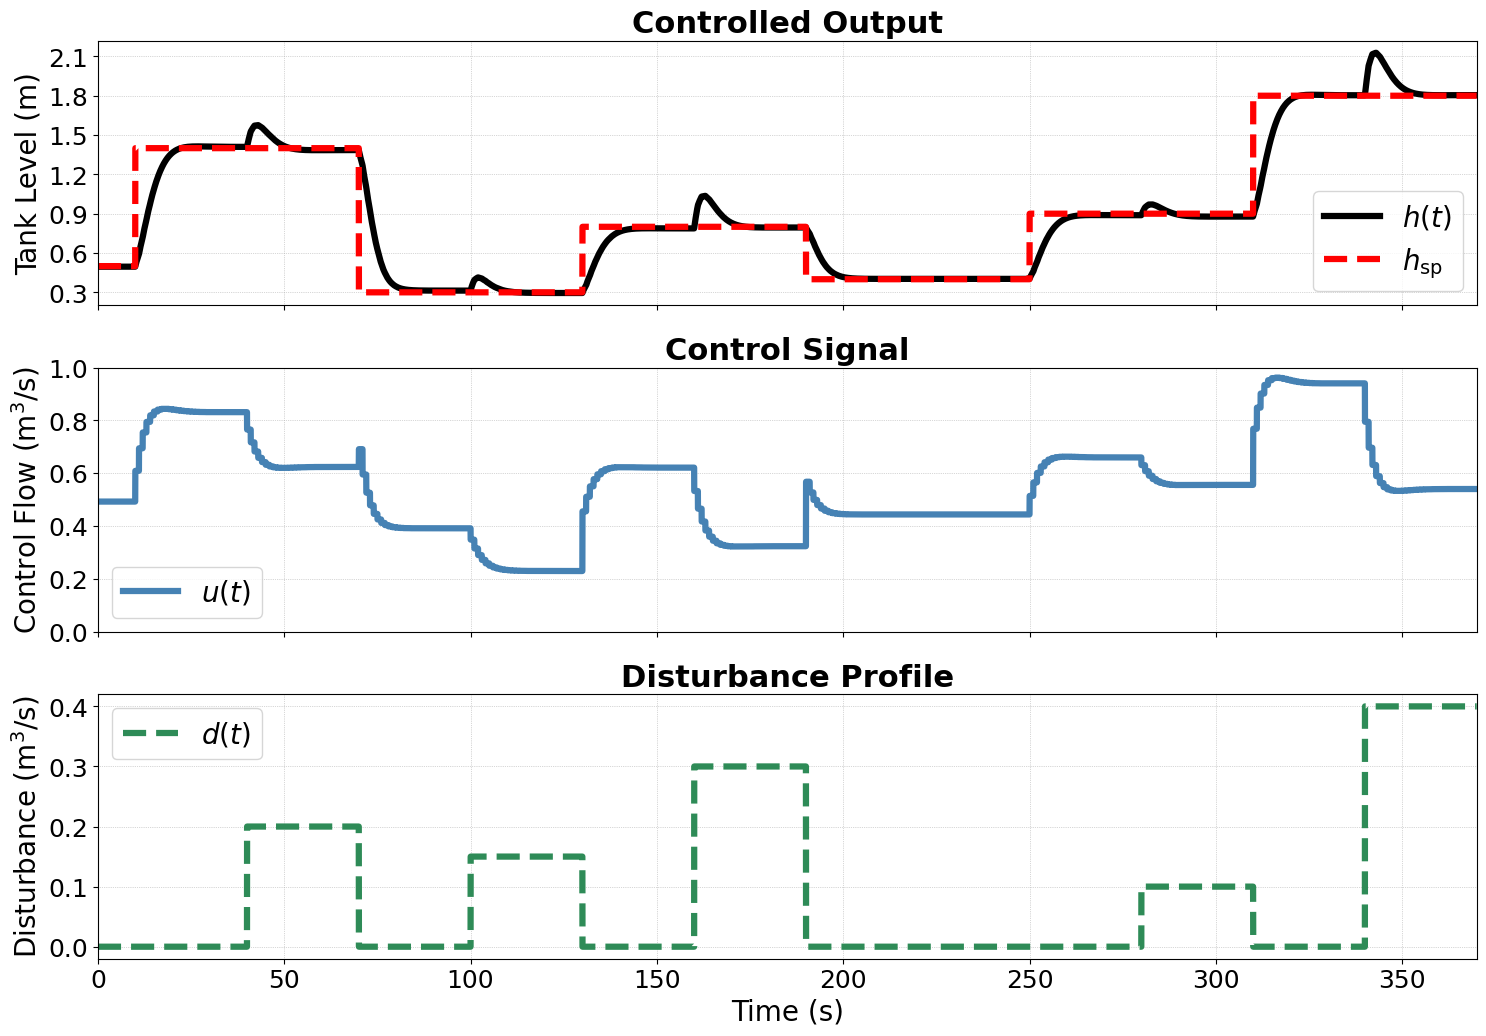

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


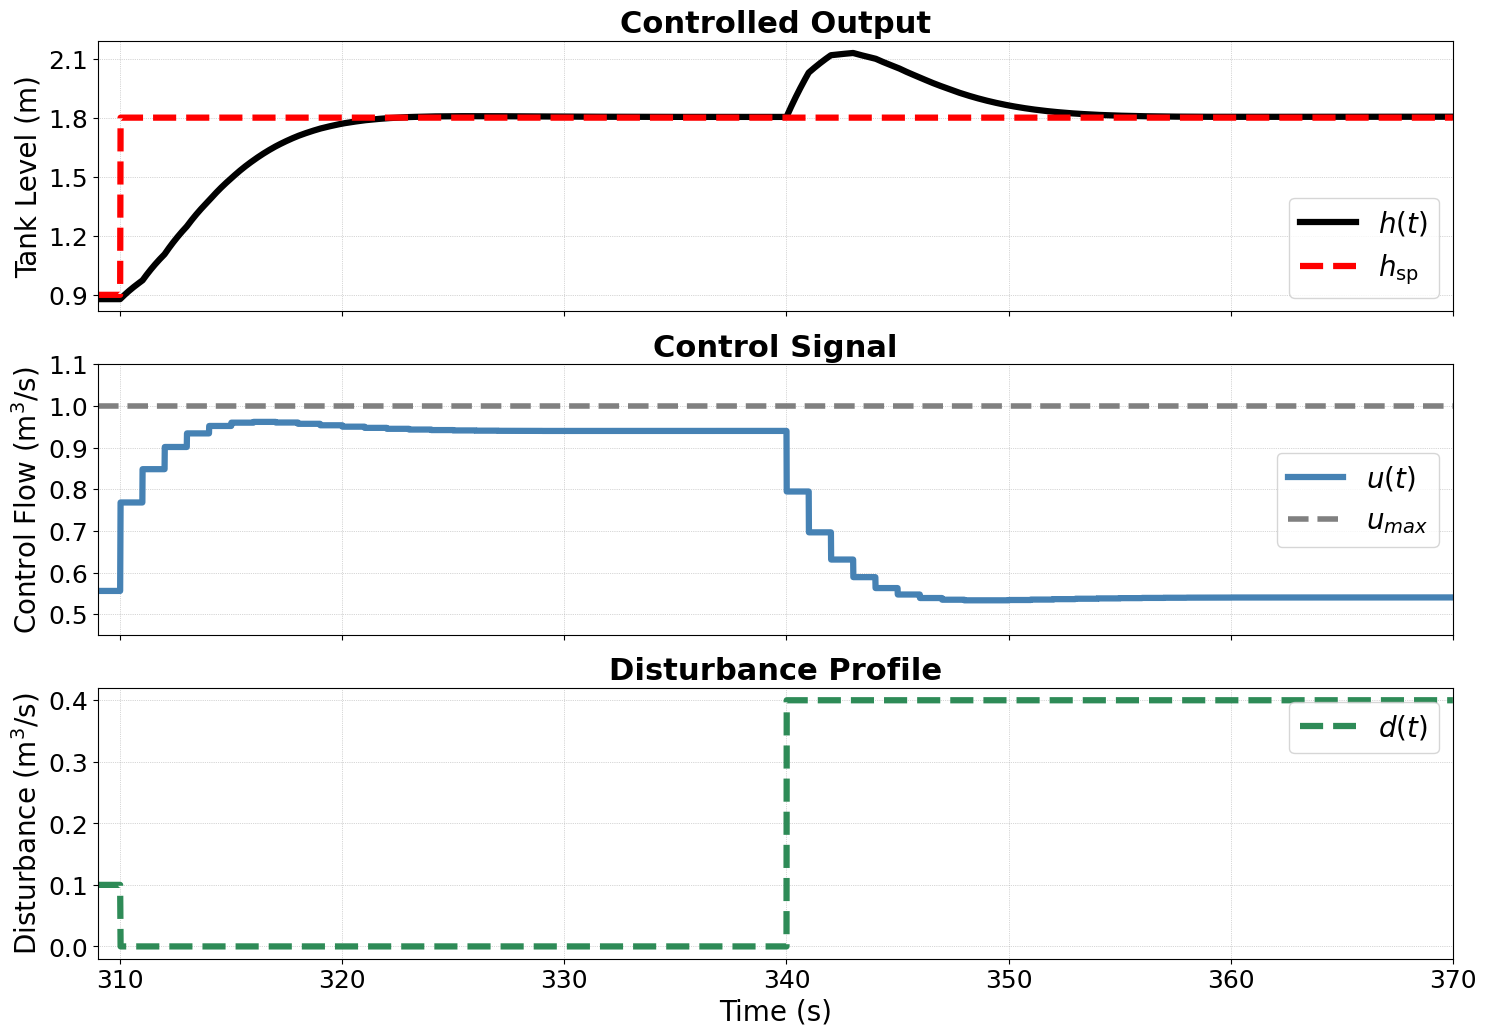

In [ ]:
## ----------- PLOT CLOSED-LOOP RESPONSE ACROSS MULTIPLE SCENARIOS ---------- ##

# Define sequences of set-points and disturbances
hsp_list = [0.5, 1.4, 0.3, 0.8, 0.4, 0.9, 1.8]     # Desired levels [m]
d0_list  = [0.0, 0.2, 0.15, 0.3, 0.0, 0.1, 0.4]    # Step disturbances [m³/s]

# Simulate multiple back-to-back scenarios and plot response
evaluate_multi_case(
    model,
    h0_test=0.5, u0_test=0.0,
    hsp_list=hsp_list,
    d0_list=d0_list,
    simulation_time=60.0,
    d_step=30.0,
    shift_time=50.0,   # Focus view on final segment
    noise=0.0
)